In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy as sp

import holodeck as holo
import holodeck.single_sources
import holodeck.detstats_randomskies as det
from holodeck.constants import YR, MSOL
from holodeck import utils


import hasasia.sensitivity as hsen
import hasasia.sim as hsim
import hasasia.skymap as hsky

# 1.) 2 pulsars, 1 binary
## 1.1 Setup
### 1.1.1 Build SAM and calculate strains

Make the semi-analytic model object.

In [6]:
hcfile = np.load('/Users/emigardiner/GWs/holodeck/ecg-notebooks/detstats_functions/sample_sam_C.npz')
dur = hcfile['dur']
cad = hcfile['cad']
fobs = hcfile['fobs']
dfobs = hcfile['dfobs']
hc_ss = hcfile['hc_ss']
hc_bg = hcfile['hc_bg']
print(hc_ss.shape)

(5, 1, 1)


### 1.1.2 Set Up 1 SS


Place the single sources randomly across the sky
Isolate the 3rd frequency bin source, place it.

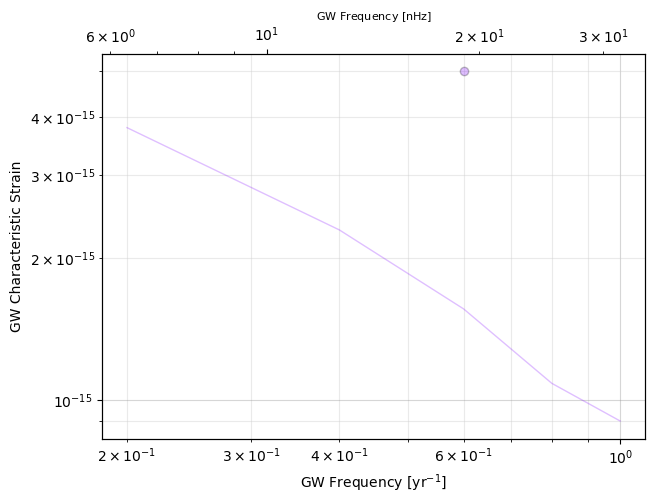

In [7]:
# theta_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
# phi_ss = np.random.uniform(0, 2*np.pi, size = hc_ss.size).reshape(hc_ss.shape)
# iota_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
# psi_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape) 
# Phi0_ss = np.random.uniform(0,2*np.pi, size=hc_ss.size).reshape(hc_ss.shape)
# np.savez('/Users/emigardiner/GWs/holodeck/ecg-notebooks/detstats_functions/random_binary_angles_C.npz',
#          theta_ss=theta_ss, phi_ss=phi_ss, iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)

infile = np.load('/Users/emigardiner/GWs/holodeck/ecg-notebooks/detstats_functions/random_binary_angles_C.npz')
theta_ss = infile['theta_ss']
phi_ss = infile['phi_ss']
iota_ss = infile['iota_ss']
psi_ss = infile['psi_ss']
Phi0_ss = infile['Phi0_ss']

# theta_ss = np.zeros_like(hc_ss)
# phi_ss = np.zeros_like(hc_ss)
iota_ss = np.zeros_like(hc_ss)
psi_ss = np.zeros_like(hc_ss)
Phi0_ss = np.zeros_like(hc_ss)

test=np.ones(theta_ss.shape)
# # special 5th bin:
ss=2
def reset_ss():
    theta_ss[ss,0,0] = np.pi/8
    phi_ss[ss,0,0] = np.pi/8
    Phi0_ss[ss,0,0] = 0
    iota_ss[ss,0,0] = 0
    psi_ss[ss,0,0] = 0
    hc_ss = np.zeros(theta_ss.shape)
    hc_ss[ss,0,0] = 5e-15
    return theta_ss, phi_ss, iota_ss, psi_ss, Phi0_ss, hc_ss
theta_ss, phi_ss, iota_ss, psi_ss, Phi0_ss, hc_ss = reset_ss()
fig = holo.plot.plot_bg_ss(fobs, hc_bg, hc_ss)

### 1.1.3 Set Up 2 Pulsars
* 2 pulsars
* 45 degrees ($\pi$/4) apart in $\phi$
* same $\theta=0$

In [8]:
# set pulsar parameters
def reset_pulsars(npsrs=2, phis = np.array([0,np.pi/4]), thetas = np.array([0,0]), 
    sigmas = np.array([1e-7,1e-7])):
    # build sim_pta
    pulsars = hsim.sim_pta(timespan=dur/YR, cad=1/(cad/YR), sigma=sigmas,
                        phi=phis, theta=thetas)
    # get spectrum for each
    spectra = np.empty_like(pulsars, dtype=hsen.Spectrum)
    for ii in range(npsrs):
        spectra[ii] = hsen.Spectrum(pulsars[ii], freqs=fobs)
        spectra[ii].NcalInv # calculate inverse noise weighted transmission function
    # get sensitivity curve
    scDeter = hsen.DeterSensitivityCurve(list(spectra))
    skymap = hsky.SkySensitivity(list(spectra), theta_gw=theta_ss.squeeze(), 
                                 phi_gw=phi_ss.squeeze(),
                                 iota=iota_ss.squeeze(), psi=psi_ss.squeeze())
    return npsrs, thetas, phis, sigmas, pulsars, spectra, scDeter, skymap
npsrs, thetas, phis, sigmas, pulsars, spectra, scDeter, skymap = reset_pulsars()

## 1.2 SNR 

### 1.2.1 skymap 
Using hasasia.skysensitivity.skymap, including iota or psi

In [9]:
hs = holo.utils.char_strain_to_strain_amp(hc_ss, fobs, dfobs)
iota_ss[ss,0,0] = np.pi/4
psi_ss[ss,0,0] = np.pi/4
np.set_printoptions(precision=2)
    
print('iota_ss', iota_ss[:,0,0])
print('psi_ss', psi_ss[:,0,0])

print('\trho1: None, None')
rho1 = skymap.SNR(hs[:,0,0], iota=None, psi=None)
print('rho1[:,ss]', rho1[:,ss])
print('rho1[ss,:]', rho1[ss,:])

print('\trho2: iota, None')
rho2 = skymap.SNR(hs[:,0,0], iota=iota_ss, psi=None)
print('rho2[:,ss]', rho2[:,ss])
print('rho2[ss,:]', rho2[ss,:])


print('\trho3: None, psi')
rho3 = skymap.SNR(hs[:,0,0], iota=None, psi=psi_ss)
print('rho3[:,ss]', rho3[:,ss])
print('rho3[ss,:]', rho3[ss,:])

print('rho1=rho2:', np.all(rho1==rho2))
print('rho1=rho3:', np.all(rho1==rho3))

iota_ss [0.   0.   0.79 0.   0.  ]
psi_ss [0.   0.   0.79 0.   0.  ]
	rho1: None, None
rho1[:,ss] [4.48e-01 2.94e-01 1.70e-01 7.83e-10 6.26e-10]
rho1[ss,:] [0.   0.   0.17 0.   0.  ]
	rho2: iota, None
rho2[:,ss] [4.48e-01 2.94e-01 1.70e-01 7.83e-10 6.26e-10]
rho2[ss,:] [0.   0.   0.17 0.   0.  ]
	rho3: None, psi
rho3[:,ss] [4.48e-01 2.94e-01 1.70e-01 7.83e-10 6.26e-10]
rho3[ss,:] [0.   0.   0.17 0.   0.  ]
rho1=rho2: True
rho1=rho3: True


In [10]:
test_iota = np.pi/2
test_psi = np.pi/2
iota_ss[ss,0,0] = test_iota
psi_ss[ss,0,0] = test_psi
    

print('\n\tiota=None and psi=None')
snr_sky1 = det.snr_skymap(skymap, fobs, dfobs, hc_ss,
                          iota_ss=None, psi_ss=None, debug=True)
print('snr_sky =',snr_sky1.shape,
       (snr_sky1.squeeze()))

print('\n\tiota=None and psi=%.2fpi' % (test_psi/np.pi))
snr_sky2 = det.snr_skymap(skymap, fobs, dfobs, hc_ss, 
                          iota_ss=None, psi_ss=psi_ss, debug=True)
print('snr_sky =',snr_sky2.shape,
       (snr_sky2.squeeze()))

print('\n\tiota=%.2fpi and psi=None' % (test_iota/np.pi))
snr_sky3 = det.snr_skymap(skymap, fobs, dfobs, hc_ss,
                          iota_ss=iota_ss, psi_ss=None, debug=True)
print('snr_sky =',snr_sky3.shape,
       (snr_sky3.squeeze()))


	iota=None and psi=None
hc_ss[:,rr,ll] (5,)
iota = None psi = None
rho (5,)
snr_sky = (5, 1, 1) [0.   0.   0.17 0.   0.  ]

	iota=None and psi=0.50pi
hc_ss[:,rr,ll] (5,)
iota = None psi = [0.   0.   1.57 0.   0.  ]
rho (5,)
snr_sky = (5, 1, 1) [0.   0.   0.17 0.   0.  ]

	iota=0.50pi and psi=None
hc_ss[:,rr,ll] (5,)
iota = [0.   0.   1.57 0.   0.  ] psi = None
rho (5,)
snr_sky = (5, 1, 1) [0.   0.   0.17 0.   0.  ]


### 1.2.2 scDeter
using hasasia.sensitivity.DeterSensitivityCurve

In [11]:
snr_sky4 = det.snr_scDeter(scDeter, fobs, dfobs, hc_ss, debug=True)
print('snr_sky =',snr_sky4.shape,
       (snr_sky4.squeeze()))

snr_sky = (5, 1, 1) [0.   0.   0.14 0.   0.  ]


# 2.) Realistic random sample
## 2.1 Setup
### 2.1.1 Build SAM and calculate strain

In [1]:
# dur = 10.0*YR
# cad = .2*YR
# fobs = utils.nyquist_freqs(dur,cad)
# fobs_edges = utils.nyquist_freqs_edges(dur,cad)
# sam = holo.sam.Semi_Analytic_Model() 
# # sam = holo.sam.Semi_Analytic_Model(mtot=(1.0e4*MSOL, 1.0e11*MSOL, 20), mrat=(1e-3, 1.0, 20), redz=(1e-3, 10.0, 20))  # faster version
# hard = holo.hardening.Hard_GW
# fobs_orb_edges = fobs_edges / 2.0 
# fobs_orb_cents = fobs/ 2.0
# # edges
# edges, dnum = sam.dynamic_binary_number(hard, fobs_orb=fobs_orb_cents) # should the zero stalled option be part of the parameter space?
# edges[-1] = fobs_orb_edges
# dfobs = np.diff(edges[-1])
# # integrate for number
# number = utils._integrate_grid_differential_number(edges, dnum, freq=False)
# number = number * np.diff(np.log(fobs_edges)) 
# hc_ss, hc_bg = holo.single_sources.ss_gws(edges, number, realize=1, 
#                                         loudest = 1, params = False) 
# np.savez('/Users/emigardiner/GWs/holodeck/ecg-notebooks/detstats_functions/sample_sam_D.npz', 
#          dur=dur, cad=cad, fobs=fobs, dfobs=dfobs, hc_ss=hc_ss, hc_bg=hc_bg)
hcfile = np.load('/Users/emigardiner/GWs/holodeck/ecg-notebooks/detstats_functions/npz_arrays/sample_sam_D.npz')
dur = hcfile['dur']
cad = hcfile['cad']
fobs = hcfile['fobs']
dfobs = hcfile['dfobs']
hc_ss = hcfile['hc_ss']
hc_bg = hcfile['hc_bg']
print(hc_ss.shape)
fig = holo.plot.plot_bg_ss(fobs, hc_bg, hc_ss)

NameError: name 'np' is not defined

### 2.1.2 Place random SS

In [13]:
# theta_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
# phi_ss = np.random.uniform(0, 2*np.pi, size = hc_ss.size).reshape(hc_ss.shape)
# iota_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
# psi_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape) 
# Phi0_ss = np.random.uniform(0,2*np.pi, size=hc_ss.size).reshape(hc_ss.shape)
# np.savez('/Users/emigardiner/GWs/holodeck/ecg-notebooks/detstats_functions/random_binary_angles_D.npz',
#          theta_ss=theta_ss, phi_ss=phi_ss, iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)

infile = np.load('/Users/emigardiner/GWs/holodeck/ecg-notebooks/detstats_functions/npz_arrays/andom_binary_angles_D.npz')
theta_ss = infile['theta_ss']
phi_ss = infile['phi_ss']
iota_ss = infile['iota_ss']
psi_ss = infile['psi_ss']
Phi0_ss = infile['Phi0_ss']

### 2.1.3 Place 40 random pulsars

In [14]:
npsrs = 40
phis = np.random.uniform(0, 2*np.pi, size = npsrs)
thetas = np.random.uniform(np.pi/2, np.pi/2, size = npsrs)
sigmas = np.ones_like(phis)*1e-7

# build sim_pta
pulsars = hsim.sim_pta(timespan=dur/YR, cad=1/(cad/YR), sigma=sigmas,
                    phi=phis, theta=thetas)
# get spectrum for each
spectra = np.empty_like(pulsars, dtype=hsen.Spectrum)
for ii in range(npsrs):
    spectra[ii] = hsen.Spectrum(pulsars[ii], freqs=fobs)
    spectra[ii].NcalInv # calculate inverse noise weighted transmission function
# get sensitivity curve
scDeter = hsen.DeterSensitivityCurve(list(spectra))
skymap = hsky.SkySensitivity(list(spectra), theta_gw=theta_ss.squeeze(), 
                                phi_gw=phi_ss.squeeze(),
                               iota=iota_ss.squeeze(),
                                psi=psi_ss.squeeze())
print(theta_ss.squeeze(), '\n', phi_ss.squeeze(), '\n', iota_ss.squeeze())

[2.71 2.79 1.6  0.19 0.62 1.64 1.81 0.22 0.21 1.85 1.9  1.03 0.93 0.38
 3.08 1.79 0.12 2.14 1.42 2.39 2.65 0.65 0.92 1.55 1.73] 
 [2.76 4.16 0.84 3.15 3.86 1.33 5.62 1.41 1.78 4.94 2.87 4.7  0.29 2.96
 2.59 6.05 5.51 4.5  4.59 5.04 5.46 5.8  4.1  2.47 1.75] 
 [1.87 0.23 1.01 1.78 0.7  0.11 0.64 0.08 3.09 2.03 0.08 0.68 0.71 0.7
 1.62 2.19 1.47 2.53 0.97 1.08 2.38 3.14 1.32 2.25 0.04]


## 2.2 SNR

### 2.2.1 skymap 
Using hasasia.skysensitivity.skymap, including iota or psi

In [15]:
hs = holo.utils.char_strain_to_strain_amp(hc_ss, fobs, dfobs)
skymap1 = hsky.SkySensitivity(list(spectra), theta_gw=theta_ss.squeeze(), 
                                phi_gw=phi_ss.squeeze(),iota=None, psi=None)
rho1 = skymap1.SNR(hs[:,0,0], iota=None, psi=None)
skymap2 = hsky.SkySensitivity(list(spectra), theta_gw=theta_ss.squeeze(), 
                                phi_gw=phi_ss.squeeze(),iota=iota_ss, psi=None)
rho2 = skymap2.SNR(hs[:,0,0], iota=iota_ss, psi=None)

skymap3 = hsky.SkySensitivity(list(spectra), theta_gw=theta_ss.squeeze(), 
                                phi_gw=phi_ss.squeeze(),iota=None, psi=psi_ss)
rho3 = skymap3.SNR(hs[:,0,0], iota=None, psi=psi_ss)

print('rho1=rho2:', np.all(rho1==rho2))
print('rho1=rho3:', np.all(rho1==rho3))
print(iota_ss.squeeze(), '\n', psi_ss.squeeze())

rho1=rho2: True
rho1=rho3: True
[1.87 0.23 1.01 1.78 0.7  0.11 0.64 0.08 3.09 2.03 0.08 0.68 0.71 0.7
 1.62 2.19 1.47 2.53 0.97 1.08 2.38 3.14 1.32 2.25 0.04] 
 [1.59 1.54 1.8  0.65 2.99 2.97 2.2  1.24 0.92 1.92 2.41 3.11 2.23 3.13
 0.12 1.83 3.12 0.66 1.94 1.6  0.06 2.02 0.97 1.   0.17]


In [16]:
hs = holo.utils.char_strain_to_strain_amp(hc_ss, fobs, dfobs)
np.set_printoptions(precision=2)
    
print('iota_ss', iota_ss[:,0,0])
print('psi_ss', psi_ss[:,0,0])

print('\trho1: None, None')
rho1 = skymap.SNR(hs[:,0,0], iota=None, psi=None)
print('rho1[:,ss]', rho1[:,ss])
print('rho1[ss,:]', rho1[ss,:])

print('\trho2: iota, None')
rho2 = skymap.SNR(hs[:,0,0], iota=iota_ss, psi=None)
print('rho2[:,ss]', rho2[:,ss])
print('rho2[ss,:]', rho2[ss,:])


print('\trho3: None, psi')
rho3 = skymap.SNR(hs[:,0,0], iota=None, psi=psi_ss)
print('rho3[:,ss]', rho3[:,ss])
print('rho3[ss,:]', rho3[ss,:])

print('rho1=rho2:', np.all(rho1==rho2))
print('rho1=rho3:', np.all(rho1==rho3))

iota_ss [1.87 0.23 1.01 1.78 0.7  0.11 0.64 0.08 3.09 2.03 0.08 0.68 0.71 0.7
 1.62 2.19 1.47 2.53 0.97 1.08 2.38 3.14 1.32 2.25 0.04]
psi_ss [1.59 1.54 1.8  0.65 2.99 2.97 2.2  1.24 0.92 1.92 2.41 3.11 2.23 3.13
 0.12 1.83 3.12 0.66 1.94 1.6  0.06 2.02 0.97 1.   0.17]
	rho1: None, None
rho1[:,ss] [1.19e+00 1.13e+00 7.80e-01 5.91e-01 4.74e-01 3.94e-01 3.36e-01 2.88e-01
 2.25e-01 3.58e-16 1.84e-01 1.92e-01 1.81e-01 1.70e-01 1.59e-01 1.49e-01
 1.41e-01 1.33e-01 1.26e-01 8.40e-02 1.14e-01 1.09e-01 1.04e-01 9.98e-02
 9.58e-02]
rho1[ss,:] [0.67 0.56 0.78 0.35 1.08 0.17 0.22 0.26 0.09 0.11 0.37 0.3  0.18 0.36
 0.05 0.37 0.07 0.26 0.1  0.36 0.06 0.19 0.13 0.25 0.07]
	rho2: iota, None
rho2[:,ss] [1.19e+00 1.13e+00 7.80e-01 5.91e-01 4.74e-01 3.94e-01 3.36e-01 2.88e-01
 2.25e-01 3.58e-16 1.84e-01 1.92e-01 1.81e-01 1.70e-01 1.59e-01 1.49e-01
 1.41e-01 1.33e-01 1.26e-01 8.40e-02 1.14e-01 1.09e-01 1.04e-01 9.98e-02
 9.58e-02]
rho2[ss,:] [0.67 0.56 0.78 0.35 1.08 0.17 0.22 0.26 0.09 0.11 0.37 0.3  0

In [17]:
# test_iota = np.pi/2
# test_psi = np.pi/2
# iota_ss[ss,0,0] = test_iota
# psi_ss[ss,0,0] = test_psi
    

print('\n\tiota=None and psi=None')
snr_sky1 = det.snr_skymap(skymap, fobs, dfobs, hc_ss,
                          iota_ss=None, psi_ss=None, debug=True)
print('snr_sky =',snr_sky1.shape,
       (snr_sky1.squeeze()))

print('\n\tiota=None and psi=%.2fpi' % (test_psi/np.pi))
snr_sky2 = det.snr_skymap(skymap, fobs, dfobs, hc_ss, 
                          iota_ss=None, psi_ss=psi_ss, debug=True)
print('snr_sky =',snr_sky2.shape,
       (snr_sky2.squeeze()))

print('\n\tiota=%.2fpi and psi=None' % (test_iota/np.pi))
snr_sky3 = det.snr_skymap(skymap, fobs, dfobs, hc_ss,
                          iota_ss=iota_ss, psi_ss=None, debug=True)
print('snr_sky =',snr_sky3.shape,
       (snr_sky3.squeeze()))


	iota=None and psi=None
hc_ss[:,rr,ll] (25,)
iota = None psi = None
rho (25,)
snr_sky = (25, 1, 1) [1.02e+00 8.16e-01 7.80e-01 2.67e-01 6.54e-01 8.48e-02 9.63e-02 9.71e-02
 2.68e-02 5.12e-17 8.66e-02 7.48e-02 4.23e-02 7.81e-02 1.06e-02 6.99e-02
 1.22e-02 4.45e-02 1.68e-02 3.88e-02 9.34e-03 2.69e-02 1.79e-02 3.14e-02
 8.26e-03]

	iota=None and psi=0.50pi
hc_ss[:,rr,ll] (25,)
iota = None psi = [1.59 1.54 1.8  0.65 2.99 2.97 2.2  1.24 0.92 1.92 2.41 3.11 2.23 3.13
 0.12 1.83 3.12 0.66 1.94 1.6  0.06 2.02 0.97 1.   0.17]
rho (25,)
snr_sky = (25, 1, 1) [1.02e+00 8.16e-01 7.80e-01 2.67e-01 6.54e-01 8.48e-02 9.63e-02 9.71e-02
 2.68e-02 5.12e-17 8.66e-02 7.48e-02 4.23e-02 7.81e-02 1.06e-02 6.99e-02
 1.22e-02 4.45e-02 1.68e-02 3.88e-02 9.34e-03 2.69e-02 1.79e-02 3.14e-02
 8.26e-03]

	iota=0.50pi and psi=None
hc_ss[:,rr,ll] (25,)
iota = [1.87 0.23 1.01 1.78 0.7  0.11 0.64 0.08 3.09 2.03 0.08 0.68 0.71 0.7
 1.62 2.19 1.47 2.53 0.97 1.08 2.38 3.14 1.32 2.25 0.04] psi = None
rho (25,)
snr_sky = (2

### 1.2.2 scDeter
using hasasia.sensitivity.DeterSensitivityCurve

In [18]:
snr_sky4 = det.snr_scDeter(scDeter, fobs, dfobs, hc_ss, debug=True)
print('snr_sky =',snr_sky4.shape,
       (snr_sky4.squeeze()))

snr_sky = (25, 1, 1) [1.76e+00 1.35e+00 9.69e-01 4.52e-01 1.09e+00 1.14e-01 1.13e-01 1.57e-01
 4.40e-02 6.70e-17 1.36e-01 1.06e-01 5.26e-02 1.34e-01 1.76e-02 7.95e-02
 1.94e-02 6.57e-02 2.35e-02 5.45e-02 1.34e-02 3.59e-02 2.84e-02 4.75e-02
 1.19e-02]
